# Visualize & Listen — Spectrogram Augmentations
This notebook demonstrates SpecAugment-style transforms (frequency/time masking + Gaussian noise) applied to mel‑spectrograms from the dataset. Run the cells in order to:

- load a small validation sample
- apply several augmentation variants
- visualize spectrograms and listen to the inverted audio (Griffin‑Lim)

Adjust augmentation parameters in the augmentation cell to experiment.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa

from dataset_utils.dataset import StudioLiveDataModule
from augmentation import SpectrogramAugmentation, ComposedAugmentation

SAMPLE_RATE = 22050
plt.rcParams['figure.dpi'] = 120

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- load a small validation sample (development_mode)
dm = StudioLiveDataModule(
    studio_dir='../../dataset/studio',
    live_dir='../../dataset/live',
    batch_size=4,
    sr=SAMPLE_RATE,
    segment_duration=0.5,
    context_length=1,        # return (n_mels, frames)
    development_mode=True,
    n_mels=128,              # make sure this matches the model / desired mel bins
    num_workers=0,
)

dm.setup()
val_loader = dm.val_dataloader()
studio_batch, live_batch = next(iter(val_loader))
print('studio_batch.shape, live_batch.shape =', studio_batch.shape, live_batch.shape)

# pick first sample
sample_idx = 0
studio_spec = studio_batch[sample_idx].cpu().numpy()   # (n_mels, frames)
live_spec = live_batch[sample_idx].cpu().numpy()

print('spectrogram shape (mel, frames):', studio_spec.shape)
print('value range (min,max):', float(studio_spec.min()), float(studio_spec.max()))

Loading Whisper model for lyric alignment...
Development mode: Loading only first pair...


Processing pairs: 100%|██████████| 1/1 [00:16<00:00, 16.99s/it, After Hours.mp3... → offset=-92.0s, sim=0.639, 320 segments of 0.5s]


Total segments: 320
Saving 320 segments to cache: ./cache/segments_cbf80d4f94f91783f91cfa8bd9e9015e.pkl
Cache saved successfully
Dataset split: 256 train, 64 val
studio_batch.shape, live_batch.shape = torch.Size([4, 128, 22]) torch.Size([4, 128, 22])
spectrogram shape (mel, frames): (128, 22)
value range (min,max): -0.1991664171218872 1.0


In [3]:
# --- helpers: convert normalized spectrogram [-1,1] -> dB -> audio (Griffin-Lim)

def _spec_to_db(normalized_spec):
    db_min, db_max = -80.0, 20.0
    return ((normalized_spec + 1.0) / 2.0) * (db_max - db_min) + db_min


def _mel_db_to_audio_hq(spec_db, sr=SAMPLE_RATE, n_iter=64):
    spec_power = librosa.db_to_power(spec_db, ref=1.0)

    stft_mag = librosa.feature.inverse.mel_to_stft(
        spec_power,
        sr=sr,
        n_fft=2048,
        power=2.0,
        fmin=20,
        fmax=8000,
    )

    audio = librosa.griffinlim(
        stft_mag,
        n_iter=n_iter,
        hop_length=512,
        win_length=2048,
        window='hann',
        momentum=0.99,
        init='random',
    )

    peak = np.max(np.abs(audio))
    if peak > 1e-8:
        audio *= (0.95 / peak)

    return audio

In [4]:
# --- configure augmentation and produce several augmented variants
spec_aug = SpectrogramAugmentation(
    freq_mask_param=20,
    time_mask_param=40,
    num_freq_masks=2,
    num_time_masks=2,
    noise_std=0.02,
    p=1.0,
)
# must enable training mode so augmentation is applied
spec_aug.train()

orig = torch.from_numpy(studio_spec).float()        # (n_mels, frames)
orig_ch = orig.unsqueeze(0)                          # (C, F, T)

n_variants = 4
augmented_specs = []
for i in range(n_variants):
    aug = spec_aug(orig_ch.clone()).squeeze(0).numpy()
    augmented_specs.append(aug)

# invert to audio for listening (use fewer iterations for quick preview)
orig_audio = _mel_db_to_audio_hq(_spec_to_db(studio_spec), sr=SAMPLE_RATE, n_iter=32)
aug_audios = [
    _mel_db_to_audio_hq(_spec_to_db(a), sr=SAMPLE_RATE, n_iter=32) for a in augmented_specs
]


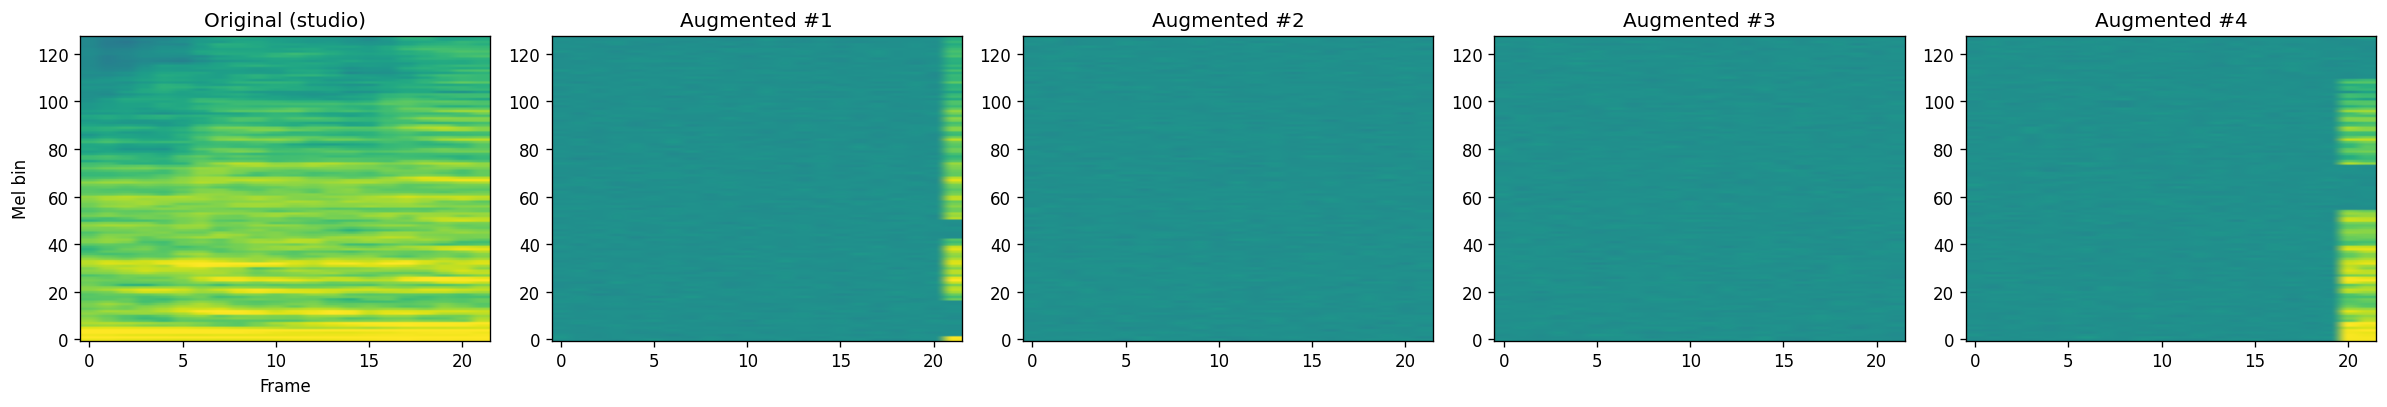

▶️ Original:


▶️ Augmented #1:


▶️ Augmented #2:


▶️ Augmented #3:


▶️ Augmented #4:



RMS (original vs augmented):
  original: 0.195470
  aug#1: 0.046342
  aug#2: 0.174096
  aug#3: 0.164324
  aug#4: 0.075852


In [5]:
# --- visualize spectrograms and play audio
import matplotlib

ncols = 1 + len(augmented_specs)
fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 3.5))
axes = np.atleast_1d(axes)

axes[0].imshow(studio_spec, aspect='auto', origin='lower', cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Original (studio)')
axes[0].set_ylabel('Mel bin')
axes[0].set_xlabel('Frame')

for i, aug in enumerate(augmented_specs, start=1):
    axes[i].imshow(aug, aspect='auto', origin='lower', cmap='viridis', vmin=-1, vmax=1)
    axes[i].set_title(f'Augmented #{i}')

plt.tight_layout()
plt.show()

# play audio
print('▶️ Original:')
display(Audio(orig_audio, rate=SAMPLE_RATE))

for i, a in enumerate(aug_audios, start=1):
    print(f'▶️ Augmented #{i}:')
    display(Audio(a, rate=SAMPLE_RATE))

# simple loudness check
rms = lambda x: np.sqrt(np.mean(x**2))
print('\nRMS (original vs augmented):')
print(f'  original: {rms(orig_audio):.6f}')
for i, a in enumerate(aug_audios, start=1):
    print(f'  aug#{i}: {rms(a):.6f}')

### Notes & tips
- Augmentations are applied to normalized mel spectrograms in [-1, 1]. Inversion uses Griffin‑Lim (approximate).
- Reduce `n_iter` in `_mel_db_to_audio_hq` for faster previews; increase for higher quality.
- To try other parameters, edit the augmentation cell and re-run the notebook.

Possible next steps: compare model outputs with / without augmentation, or create saved examples under `spectrograms/augmentations/` for side‑by‑side listening.